# Bike sharing Demand

[캐글 자전거 대여수요](https://www.kaggle.com/c/bike-sharing-demand/overview)

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

In [30]:
bike = pd.read_csv('data/bike_train.csv')

In [31]:
bike.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [32]:
bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


* datetime : hourly date + timestemp
* season : 1 = 봄 , 2= 여름, 3= 가을 4= 겨울
* holiday : 1 = 주말을 제외한 국경일 등의 휴일, 0 = 휴일이 아닌 날 
* workingday : 1 = 주말/휴일이 아닌 주중, 0 = 주말 및 휴일 
* weather : 1 = 맑음, 2 = 안개 / 흐림 , 3 = 가벼운 비/눈 + 천둥 , 4 = 심한 눈/비 + 천둥/번개
* temp : 온도(섭씨)
* atemp : 체감온도(섭씨)
* humidity : 상대습도
* windspeed : 풍속
* casual : 사전에 등록되지 않은 사용자가 대여한 횟수
* registerd : 사전에 등록한 사용자가 대여한 횟수 
* count : 전체 대여 횟수

In [33]:
bike['datetime'] = bike.datetime.apply(pd.to_datetime)

In [34]:
bike['year'] = bike.datetime.apply(lambda x : x.year)
bike['month'] = bike.datetime.apply(lambda x : x.month)
bike['day'] = bike.datetime.apply(lambda x : x.day)
bike['hour'] = bike.datetime.apply(lambda x : x.hour)

bike.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2


In [35]:
bike.drop(['datetime','casual','registered'], axis = 1, inplace= True)

count = casual + registered 임으로 상관성이 높아 예측을 저해할 우려가 있음.  

In [36]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [83]:
# log 변환 시 NaN 등의 이슈로 log1p()을 이용 

def rmsle(y, pred) :
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    
    squared_error = (log_y - log_pred)**2
    rmsle = np.sqrt(np.mean(squared_error))
    
    return rmsle

def rmse(y, pred):
    return np.sqrt(mean_squared_error(y, pred))

def evaluate_regr(y, pred) :
    rmsle_val = rmsle(y, pred)
    rmse_val = rmse(y, pred)
    mse_val = mean_absolute_error(y, pred)
    
    print('RMSLE :{:.3f} RMSE :{:.3f} MSE :{:.3f}\n'.format(rmsle_val,rmse_val,mse_val))

In [38]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV

In [71]:
y_target = bike['count']
x_features = bike.drop(['count'], axis = 1)

In [72]:
X_train, X_test, y_train, y_test = train_test_split(x_features, y_target, test_size = 0.3, random_state = 0)

In [73]:
lr_reg =LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

evaluate_regr(y_test, pred)

RMSLE :1.165 RMSE :140.900 MSE :105.924


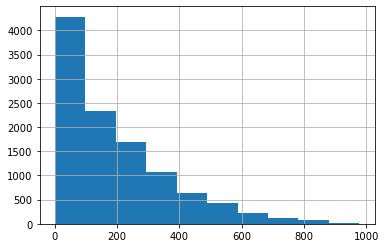

In [53]:
y_target.hist()

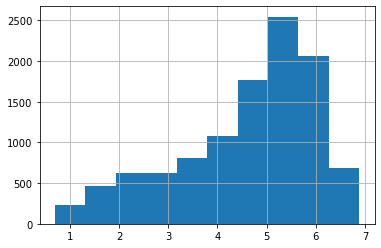

In [55]:
y_log_transform = np.log1p(y_target)
y_log_transform.hist()

#### target : count 로그 변환 후 학습 

In [57]:
X_train, X_test, y_train, y_test = train_test_split(x_features, y_log_transform, test_size = 0.3, random_state = 0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

y_test_exp = np.expm1(y_test) # 원래 스케일로 변환
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp, pred_exp)

RMSLE :1.017 RMSE :162.594 MSE :109.286


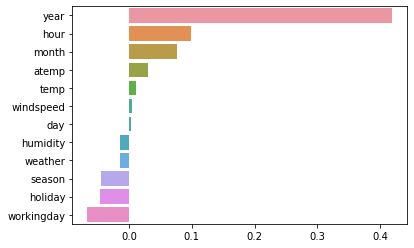

In [59]:
coef = pd.Series(lr_reg.coef_, index = x_features.columns)
coef_sort = coef.sort_values(ascending = False)
sns.barplot(x=coef_sort, y = coef_sort.index)

In [60]:
bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10886 non-null  int64  
 1   holiday     10886 non-null  int64  
 2   workingday  10886 non-null  int64  
 3   weather     10886 non-null  int64  
 4   temp        10886 non-null  float64
 5   atemp       10886 non-null  float64
 6   humidity    10886 non-null  int64  
 7   windspeed   10886 non-null  float64
 8   count       10886 non-null  int64  
 9   year        10886 non-null  int64  
 10  month       10886 non-null  int64  
 11  day         10886 non-null  int64  
 12  hour        10886 non-null  int64  
dtypes: float64(3), int64(10)
memory usage: 1.1 MB


`year` 은 연도를 뜻하면 카테고리 형 변수지만 숫자형으로 지정되어 있음.   
이를 원-핫 인코딩을 적용하여 숫자로 변화해주어야 함 

In [62]:
# year, month, hour, holiday, woringday, season, weather : 원-핫 인코딩 

X_features_ohe = pd.get_dummies(x_features, columns = ['year', 'month', 'hour', 
                                                       'holiday','workingday','season', 'weather'])

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_log_transform, test_size = 0.3, random_state = 0)

In [84]:
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1 = False):
    model.fit(X_train, y_train)
    pred= model.predict(X_test)
    
    if is_expm1 : 
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    
    print('###', model.__class__.__name__, "###")
    
    evaluate_regr(y_test, pred)

In [87]:
lr = LinearRegression()
ridge = Ridge(alpha = 10)
lasso = Lasso(alpha = 0.01)

In [88]:
for model in [lr, ridge, lasso] :
    get_model_predict(model, X_train, X_test, y_train, y_test, True)

### LinearRegression ###
RMSLE :0.589 RMSE :97.484 MSE :63.106

### Ridge ###
RMSLE :0.589 RMSE :98.407 MSE :63.648

### Lasso ###
RMSLE :0.634 RMSE :113.031 MSE :72.658



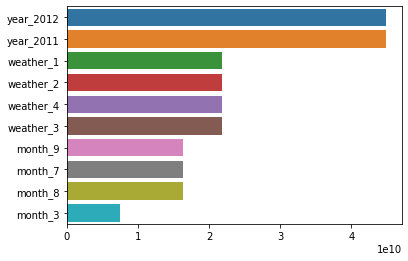

In [90]:
coef = pd.Series(lr.coef_, index = X_features_ohe.columns)
coef_sort = coef.sort_values(ascending = False)[:10]
sns.barplot(coef_sort.values, y = coef_sort.index)